### Understanding Geospatial Data
This notebook will take you through some of the basic principles of working with geospatial datasets and give you an introduction to the ACLED conflict dataset we will be using.
#### Conflict tasks to get started
- How can we use the conflict events define an area as being affected by conflict?
- Each event is given a free text description. Can we extract useful information from this column?
- How/should we treat conflict events differently when they target civilians?

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
sys.path.insert(0, module_path)

In [3]:
import pandas as pd
import geopandas as gpd
import os 
import io
module_path = os.path.abspath(os.path.join('../src'))
os.chdir(module_path)
from data.utils import *
import zipfile
import tempfile
import shutil
import matplotlib.pyplot as plt

### What is geospatial data?

Geospatial (spatial) data refers to any form of data that contains information about geographic locations. In our context, it's easiest to think of geospatial datasets as through the `GeoDataFrame` object provided by the package `geopandas`. These dataframes are much like any other tabular data - rows and colunms with values inside each cell - but augemented with a special column called `geometry` that contains spatial information. This column can contain `points` (e.g. locations of conflict events), `linestrings` (e.g. road networks), or `polygons` (e.g. national or subnational boundaries). Below, we load the Kenya's county boundaries from the Humanitarian Data Exchange using a custom utility function.

##### NOTE: The default nest environment res_latest contains some package incompatibilies that can cause a `NotImplementedError` during some file reads. If you encounter this problem, the best solution is to create a nest envirorment as outlined in the README. Once you've created and activated your nest, run `pip install shapely --upgrade`. You should now be able to run the below cell without issue (so long as you use your custom nest).

In [4]:
kenya_counties = load_data(bucket=BUCKET, path = "BOUNDARIES/ADMIN_1/Africa_bnd_adm1.shp").query("adm0_name == 'Kenya'")
kenya_counties.head()

,OBJECTID,iso3,adm1_name,adm1_altnm,adm1_id,adm0_name,adm0_id,mapclr,rb,disp_area,salb_id,source,source_id,source_dat,lst_update,validity,shape_Leng,shape_Area,ucode,geometry
382,2493,KEN,Baringo,NaN,903882,Kenya,133,KEN,RBN,no,NaN,OCHA (ROSEA),KE030,2018-07-03,2023-01-16,0,5.932315,0.884732,KEN_0001_V1,"POLYGON ((35.78390 1.65557, 35.78496 1.65554, ..."
383,2494,KEN,Bomet,NaN,903883,Kenya,133,KEN,RBN,no,NaN,OCHA (ROSEA),KE036,2018-07-03,2023-01-16,0,2.922220,0.198099,KEN_0002_V1,"POLYGON ((35.47360 -0.39920, 35.47845 -0.40663..."
384,2495,KEN,Bungoma,NaN,903884,Kenya,133,KEN,RBN,no,NaN,OCHA (ROSEA),KE039,2018-07-03,2023-01-16,0,3.058455,0.244211,KEN_0003_V1,"POLYGON ((34.62385 1.09989, 34.62463 1.09907, ..."
385,2496,KEN,Busia,NaN,903885,Kenya,133,KEN,RBN,no,NaN,OCHA (ROSEA),KE040,2018-07-03,2023-01-16,0,2.641988,0.145977,KEN_0004_V1,"POLYGON ((34.36734 0.77358, 34.36814 0.77290, ..."
386,2497,KEN,Elgeyo-Marakwet,NaN,903886,Kenya,133,KEN,RBN,no,NaN,OCHA (ROSEA),KE028,2018-07-03,2023-01-16,0,3.888933,0.244432,KEN_0005_V1,"POLYGON ((35.69818 1.28225, 35.69788 1.27905, ..."


Looking at the table above, we see the `geometry` contains a mixture 'polygon' and `multipolygon` (a collection of polygons) values. Polygons are structured as a collection of coordinates that define the perimeter of a particular area. For instance, we can plot the first polygon in our dataframe to see its shape:

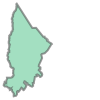

In [5]:
kenya_counties["geometry"].iloc[0]

We can also easily plot the full boundaries colored by area:

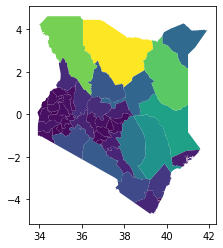

In [6]:
kenya_counties.plot(column = "shape_Area")

Next, we'll load the ACLED conflict dataset. We can see that the dataframe contains information on the date, involved actors, whether civilians were target, etc. for each conflict event. There is also a free text column `notes`.  

In [7]:
df = load_data(BUCKET, "CONFLICT/ACLED_data_Africa_Ucodes.csv").reset_index()
df.head(1)

,OID_,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,...,source,source_scale,notes,fatalities,tags,timestamp,ucode_level0,ucode_level1,ucode_level2,ucode
0,1,BFO11038,17 November 2023,2023,1,Political violence,Violence against civilians,Attack,JNIM: Group for Support of Islam and Muslims,NaN,...,BurkinaWeb; Facebook,New media-National,"On 17 November 2023, JNIM militants killed fiv...",5,NaN,1700524094,BFA_V1,BFA_0001_V1,BFA_0001_0003_V1,BFA_V1


Although the dataframe contains latitude/longitude columns, it is not yet a `GeoDataFrame`. Below, we use the the `geopandas` function `points_from_xy` to create a `point` geometry column and transform the dataframe into a `GeoDataFrame`.

In [8]:
conflict_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude'])).set_crs(4326)
conflict_gdf[["event_id_cnty", "event_type", "geometry"]].head(3)

,event_id_cnty,event_type,geometry
0,BFO11038,Violence against civilians,POINT (-3.92110 12.76470)
1,BFO11043,Strategic developments,POINT (1.36290 12.00690)
2,MLI31293,Explosions/Remote violence,POINT (3.02240 15.42200)


### Spatial joins

The geographic information contained in a spatial dataframe makes geographic operations possible. Our `conflict_gdf` geodataframe contain the point locations of instances of violence across Africa. In the visualiztion below, we plot a random sample of the points onto Kenya's county boundaries.

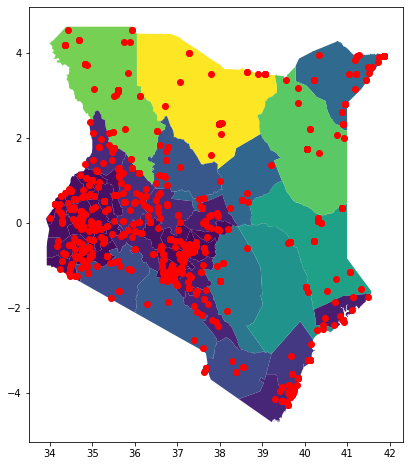

In [10]:
fig, ax = plt.subplots(figsize=(18, 8))
kenya_counties.plot(ax = ax, column = "shape_Area")
conflict_gdf.query("country == 'Kenya'").sample(1000).plot(ax = ax, color = "red")

 The figure provides visual intuition of where events tend to be located. To get more specific, we can use the `geopandas` function `overlay` to intersect these point locations with Kenya's subnational boundaries to identify which county each instance occured in. In the first three rows of the data, we see that the point geometry has been preserved but we now have the county name from our subnational boundaries geodataframe.

In [12]:
kenya_conflict = conflict_gdf.overlay(kenya_counties)
kenya_conflict[["event_id_cnty", "adm1_name", "geometry"]].head(3)

,event_id_cnty,adm1_name,geometry
0,KEN13010,Nairobi,POINT (36.81700 -1.28300)
1,KEN13018,Nairobi,POINT (36.81700 -1.28300)
2,KEN13037,Nairobi,POINT (36.77890 -1.27930)


Using the spatially joined data we can identify the total number of conflicts in each county and find out which counties have seen the highest number of events. 

In [15]:
kenya_conflict.groupby("adm1_name")["event_id_cnty"].count().reset_index().sort_values("event_id_cnty", ascending=False).head(5)

,adm1_name,event_id_cnty
29,Nairobi,2065
30,Nakuru,585
6,Garissa,547
27,Mombasa,507
23,Mandera,498


### Coordinate Reference Systems

Representing points on the Earth requires a system defining how the coordinate map to locations on the Earth's surface. There are many different coordinate reference systems (CRS) for representing locations on Earth. Some of these, like the common WGS84 latitude/longitude system are called 'geographic' because they map coordinates to locations on a sphere. Others, called 'planar' CRS project the Earth's surface onto a 2D grid. 

The GeoDataFrame's coordinate reference system matters for spatial operations. In our case, we were able to perform the join above because both dataframes are in WGS84. Since the coordinates in a geographic CRS are points on a sphere rather than in planar space, it's not possible to measure distances using the conventional euclidean distance metric. To estimate distances, we need to reproject the `GeoDataFrame` into an appropriate planar CRS using the `to_crs` function. All planar CRS distort some combination of area, distance, or shape, so it's important to select one carefully. Below, we use `EPSG:3857`, ('Web Mercator') which has limited distortion in areas not close to the northern or southern poles.

One (very) basic way of defining an area affected by conflict is to define a distance and consider all points within that distance of a conflict event to be affected by conflict. To define this area, we can create a `buffer` of (say) 10 kilometers around each event that occured in 2023 and join the resulting circles into a single geometry. 

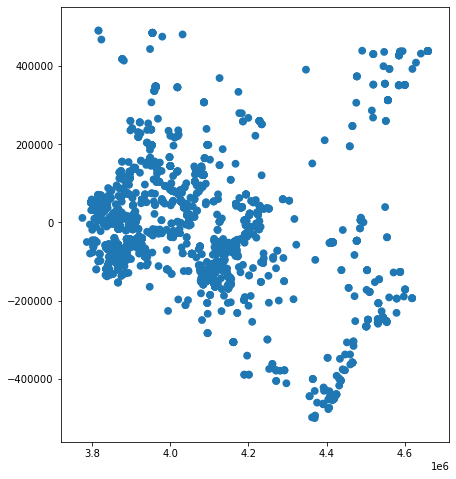

In [16]:
fig, ax = plt.subplots(figsize=(18, 8))
buffers10km = kenya_conflict.dropna(subset = "geometry").query("year == 2023").to_crs(3857).buffer(10000)
buffers10km.plot(ax=ax)

These buffer areas are now represented in the planar projection. If we wanted to perform and operations with the boundary dataset, we would need to use `to_crs` again to match the original CRS.